In [37]:
from functools import partial

import os
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

from timm.models.vision_transformer import Block
from model_mae import MaskedAutoencoder
from utils import MaskEmbed, get_1d_sincos_pos_embed, ActiveEmbed, Utils

eps = 1e-6

In [2]:
'''
remasker - the code is absolutely horrible

no documentation
no comments

The code does not run (copied as it is)
'''

'\nremasker - the code is absolutely horrible\n\nno documentation\nno comments\n\nThe code does not run (copied as it is)\n'

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda:4')
else:
    device = torch.device('cpu')

In [4]:
device

device(type='cuda', index=4)

In [5]:
path = ".."
filename = "TransferLearningData_WithWinter.csv"
model_dir = "./model/"
log_dir = "./log/"

In [6]:
pre_train_window = 35

In [7]:
filepath = os.path.join(path, filename)
df = pd.read_csv(filepath)

/tmp/ipykernel_71710/1025252231.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


In [8]:
df

,Lake,DateTime,Site,Depth_m,DataType,ModelRunType,AirTemp_C,Shortwave_Wm2,Inflow_cms,WaterTemp_C,...,LightAttenuation_Kd,Chla_ugL,Flag_AirTemp_C,Flag_Shortwave_Wm2,Flag_Inflow_cms,Flag_WaterTemp_C,Flag_SRP_ugL,Flag_DIN_ugL,Flag_LightAttenuation_Kd,Flag_Chla_ugL
0,FCR,2018-08-01,50,1.6,observed,NaN,21.69000,2.576500,0.001250,26.884,...,0.913978,4.01,0,0,0,1.0,1.0,1.0,1.0,1.0
1,FCR,2018-08-02,50,1.6,observed,NaN,21.19500,1.132500,0.003451,26.884,...,0.913978,4.01,0,0,0,1.0,1.0,1.0,1.0,1.0
2,FCR,2018-08-03,50,1.6,observed,NaN,20.29000,1.154821,0.005080,26.884,...,0.913978,4.01,0,1,0,1.0,1.0,1.0,1.0,1.0
3,FCR,2018-08-04,50,1.6,observed,NaN,23.55500,1.177141,0.003196,26.884,...,0.913978,4.01,0,1,0,1.0,1.0,1.0,1.0,1.0
4,FCR,2018-08-05,50,1.6,observed,NaN,24.73000,1.199462,0.001073,26.884,...,0.913978,4.01,0,1,0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70835,TOOK,2022-12-27,buoy,0.5,observed,NaN,-35.39290,-0.740000,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,1.0,1.0,NaN,NaN
70836,TOOK,2022-12-28,buoy,0.5,observed,NaN,-29.69685,0.575000,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,1.0,1.0,NaN,NaN
70837,TOOK,2022-12-29,buoy,0.5,observed,NaN,-22.03290,-0.675000,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,1.0,1.0,NaN,NaN
70838,TOOK,2022-12-30,buoy,0.5,observed,NaN,-13.60220,-0.980000,0.000000,NaN,...,NaN,NaN,0,0,2,NaN,1.0,1.0,NaN,NaN


In [9]:
df.Lake.unique()

array(['FCR', 'Mendota', 'Sunapee', 'BARC', 'CRAM', 'LIRO', 'PRLA',
       'PRPO', 'SUGG', 'TOOK'], dtype=object)

In [10]:
for lake in df.Lake.unique():
    lake_df = df[df['Lake']==lake]
    
    if 'modeled' in lake_df.DataType.unique():
        print(f"Lake = {lake}")
        print(lake_df[lake_df['DataType']=='modeled'].ModelRunType.unique())

Lake = FCR
['GLMAED_calibrated_observed_met']
Lake = Mendota
['GLMAED_calibrated_observed_met' 'GLMAED_calibration_temp_plus1'
 'GLMAED_calibration_temp_plus2' 'GLMAED_calibration_temp_plus3'
 'GLMAED_calibration_temp_plus4' 'GLMAED_calibration_temp_plus5'
 'GLMAED_calibration_temp_plus6']
Lake = Sunapee
['GLMAED_calibrated_observed_met' 'GLMAED_calibration_temp_plus1'
 'GLMAED_calibration_temp_plus2' 'GLMAED_calibration_temp_plus3'
 'GLMAED_calibration_temp_plus4' 'GLMAED_calibration_temp_plus5'
 'GLMAED_calibration_temp_plus6']


In [11]:
cols_to_exclude_from_features = ["Lake","Site","Depth_m","DataType","ModelRunType"]
features_col = df.columns.difference(cols_to_exclude_from_features)
features_col = [feat for feat in features_col if not 'flag' in feat.lower() and feat!='DateTime']
features_col

['AirTemp_C',
 'Chla_ugL',
 'DIN_ugL',
 'Inflow_cms',
 'LightAttenuation_Kd',
 'SRP_ugL',
 'Shortwave_Wm2',
 'WaterTemp_C']

In [12]:
# df = df.dropna(subset=features_col)
df.Lake.unique()

array(['FCR', 'Mendota', 'Sunapee', 'BARC', 'CRAM', 'LIRO', 'PRLA',
       'PRPO', 'SUGG', 'TOOK'], dtype=object)

In [13]:
date_col = ['DateTime']
date_col

['DateTime']

In [14]:
target_cols = ['Chla_ugL']
target_cols

['Chla_ugL']

In [15]:
features_col

['AirTemp_C',
 'Chla_ugL',
 'DIN_ugL',
 'Inflow_cms',
 'LightAttenuation_Kd',
 'SRP_ugL',
 'Shortwave_Wm2',
 'WaterTemp_C']

In [16]:
df.DateTime = df.DateTime.astype('datetime64[ns]')

In [17]:
# get the observed values
# target_df = df[df['Lake']=='FCR'].reset_index(drop=True)
train_df = df#[df['Lake']!='FCR'].reset_index(drop=True)

In [18]:
num_features = len(features_col)
utils = Utils(num_features=num_features,
              inp_cols=features_col, 
              date_col=date_col, 
              window=pre_train_window, 
              stride=1)

In [19]:
train_set = pd.DataFrame()
val_set = pd.DataFrame()

for lake in train_df.Lake.unique():
    lake_df = train_df[train_df['Lake']==lake]
    types = lake_df.DataType.unique()
    for dtype in types:
        lake_df = lake_df[lake_df['DataType']==dtype].reset_index(drop=True)
        train, val = utils.train_test_split(lake_df, split_type=None, split_date=None, split_ratio=0.8)
        train_set = train_set.append(train, ignore_index=True)
        val_set = val_set.append(val, ignore_index=True)

/tmp/ipykernel_71710/2516351308.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_set = train_set.append(train, ignore_index=True)
/tmp/ipykernel_71710/2516351308.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  val_set = val_set.append(val, ignore_index=True)


In [20]:
train_set = utils.normalize(train_set)

In [21]:
val_set = utils.normalize(val_set, use_stat=True)

In [22]:
train_set

,Lake,DateTime,Site,Depth_m,DataType,ModelRunType,AirTemp_C,Shortwave_Wm2,Inflow_cms,WaterTemp_C,...,LightAttenuation_Kd,Chla_ugL,Flag_AirTemp_C,Flag_Shortwave_Wm2,Flag_Inflow_cms,Flag_WaterTemp_C,Flag_SRP_ugL,Flag_DIN_ugL,Flag_LightAttenuation_Kd,Flag_Chla_ugL
0,FCR,2018-08-01,50,1.6,observed,NaN,1.042524,-0.554455,-0.769624,1.476496,...,-0.693363,-0.434683,0,0,0,1.0,1.0,1.0,1.0,1.0
1,FCR,2018-08-02,50,1.6,observed,NaN,1.001166,-0.675105,-0.769440,1.476496,...,-0.693363,-0.434683,0,0,0,1.0,1.0,1.0,1.0,1.0
2,FCR,2018-08-03,50,1.6,observed,NaN,0.925551,-0.673240,-0.769304,1.476496,...,-0.693363,-0.434683,0,1,0,1.0,1.0,1.0,1.0,1.0
3,FCR,2018-08-04,50,1.6,observed,NaN,1.198350,-0.671375,-0.769461,1.476496,...,-0.693363,-0.434683,0,1,0,1.0,1.0,1.0,1.0,1.0
4,FCR,2018-08-05,50,1.6,observed,NaN,1.296524,-0.669510,-0.769639,1.476496,...,-0.693363,-0.434683,0,1,0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54764,TOOK,2022-03-09,buoy,0.5,observed,NaN,-2.407737,-0.738396,-0.769728,NaN,...,NaN,NaN,0,0,2,NaN,1.0,1.0,NaN,NaN
54765,TOOK,2022-03-10,buoy,0.5,observed,NaN,-2.977911,-0.735890,-0.769728,NaN,...,NaN,NaN,0,0,2,NaN,1.0,1.0,NaN,NaN
54766,TOOK,2022-03-11,buoy,0.5,observed,NaN,-2.962492,-0.744245,-0.769728,NaN,...,NaN,NaN,0,0,2,NaN,1.0,1.0,NaN,NaN
54767,TOOK,2022-03-12,buoy,0.5,observed,NaN,-2.497075,-0.764715,-0.769728,NaN,...,NaN,NaN,0,0,2,NaN,1.0,1.0,NaN,NaN


In [23]:
train_X = utils.windowed_dataset_utils(train_set)
val_X = utils.windowed_dataset_utils(val_set)

Lake here has missing values = CRAM observed
Lake here has missing values = CRAM observed
Lake here has missing values = CRAM observed
Lake here has missing values = CRAM observed
Lake here has missing values = CRAM observed
Lake here has missing values = CRAM observed
Lake here has missing values = CRAM observed
Lake here has missing values = CRAM observed
Lake here has missing values = CRAM observed
Lake here has missing values = CRAM observed
Lake here has missing values = CRAM observed
Lake here has missing values = CRAM observed
Lake here has missing values = CRAM observed
Lake here has missing values = CRAM observed
Lake here has missing values = CRAM observed
Lake here has missing values = CRAM observed
Lake here has missing values = CRAM observed
Lake here has missing values = CRAM observed
Lake here has missing values = CRAM observed
Lake here has missing values = CRAM observed
Lake here has missing values = CRAM observed
Lake here has missing values = CRAM observed
Lake here 

In [24]:
train_X = torch.from_numpy(train_X).type(torch.Tensor)
val_X = torch.from_numpy(val_X).type(torch.Tensor)

In [25]:
train_X.shape

torch.Size([54429, 35, 8])

In [26]:
val_X.shape

torch.Size([13361, 35, 8])

In [39]:
from datasets import load_dataset

In [27]:
model_args = {
    'num_feats':num_features,
    'rec_len': pre_train_window,
    'embed_dim': 64,
    'depth': 2,
    'num_heads': 4,
    'decoder_embed_dim':32,
    'decoder_depth':2,
    'decoder_num_heads':4,
    'mlp_ratio':4,
    'norm_layer':partial(nn.LayerNorm, eps=eps),
    'mask_ratio':0.5
}
train_args = {
    'batch_size':32,
    'accum_iter':1,
    'min_lr':1e-5,
    'weight_decay':0.05,
    'lr': None,
    'blr': 1e-3,
    'warmup_epochs':40, #40
    'max_epochs': 600, #600
    'device':device
}

In [28]:
model = MaskedAutoencoder(**model_args)

In [29]:
train_X = train_X.reshape(train_X.shape[0], train_X.shape[2], train_X.shape[1])
val_X = val_X.reshape(val_X.shape[0], val_X.shape[2], val_X.shape[1])

In [30]:
loss = model.train_model(train_X, val_X, train_args)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 600/600 [7:25:41<00:00, 44.57s/it, batch_loss=131, total_loss=0.389]


(MaskedAutoencoder(
   (mask_embed): MaskEmbed(
     (proj): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
     (norm): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
   )
   (blocks): ModuleList(
     (0): Block(
       (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
       (attn): Attention(
         (qkv): Linear(in_features=64, out_features=192, bias=True)
         (q_norm): Identity()
         (k_norm): Identity()
         (attn_drop): Dropout(p=0.0, inplace=False)
         (proj): Linear(in_features=64, out_features=64, bias=True)
         (proj_drop): Dropout(p=0.0, inplace=False)
       )
       (ls1): Identity()
       (drop_path1): Identity()
       (norm2): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
       (mlp): Mlp(
         (fc1): Linear(in_features=64, out_features=256, bias=True)
         (act): GELU(approximate=none)
         (drop1): Dropout(p=0.0, inplace=False)
         (norm): Identity()
         (fc2): Linear(in_features=256, out_featu

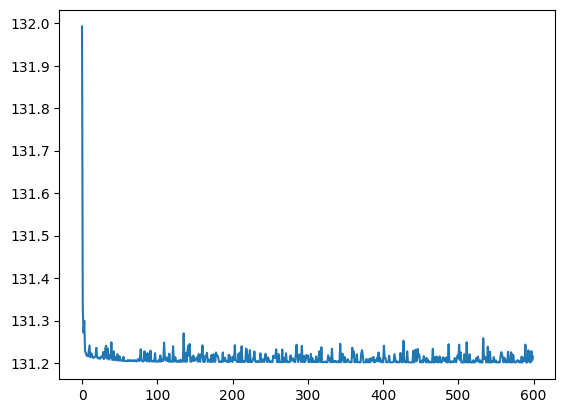

In [38]:
plt.plot(loss)

In [31]:
torch.save(model, 'mae_v0.pth')

In [49]:
mm = torch.load('temp.pth')

In [ ]:
# TODO

# 1. Interpolation-based filtering
# 4. Evaluate on val set (includes FCR)